# Reinforcement Learning

# I. Overview
# Objective
Implement reinforcement learning to train an agent to play rummy.

## Tasks Performed:
1. Understood the agents defined for playing rummy.
2. Understand SARSA and Q-learning tabular approaches for reinforcement learning basics.
3. Implement the Q-learning tabular approach to build a reinforcement learning agent to improve playing rummy.

# II. Problems 



## Rummy (Customized)
![](https://upload.wikimedia.org/wikipedia/commons/9/9a/3_playing_cards.jpg)



### Description:
Rummy is mostly played by 4 players where each player get 10 cards and rest of placed as closed deck.  

But for this assignment to keep it simple, we have changed some rules, reduced the deck of cards and distribution of the cards among each player. Otherwise, the our Q table would be large to handle on our local machines.  

So in this game each player will get 3 cards randomly from 'A' to '5'. With each turn you have to pick a card either from the pile of closed or open cards depending on the cards you have. After that you have to select a card to drop to the pile from your deck. Your goal is to make all of your 3 cards of same number. As soon as one player reaches the goal state, it will meld the cards and game will stop and all other player will get score as the sum of their cards in hand. Player with minimum score will win the game.  

Each player will play for the 10 rounds and if nobody reach to the meld stage then each will player will get score equivalent to the sum of their cards in hand.

Player with the lowest score wins the game.



### <font color="blue"> Game Introduction and Rules: </font>

You can only till max turns which is now 20. If you are able to meld your cards, you win otherwise you lose points as per your stash score.

Lets Simulate a Game Round :
The Goal of this game is to collect cards with the same rank.
Naming Conventions to follow H : Hearts, S : Spades, D : Diamonds, C : Clubs. Stash/Hand are the cards which you have. Stash/Hand Score: The sum of the rank of cards. 

- On the first turn you will be given 3 cards from the randomly shuffled deck. Eg: 3H, 2S, AD. Stash Score: 6
- In the next step you will have to either pick a card from pile or the deck. On the first turn, the top card of the deck is on the pile. The card on the pile is visible to you. So Card on the Pile : 2D . You have to decide whether you have to pick this card or you have to pick from pile. Since you alread
- Following the pickup step, you will have to drop one card from the stash/hand. Your Hand : 3H, 2S, AD, 2D
- You can drop any of these cards, but remember if you drop 2S or 2D you might not be able to make a series. So you have to decide whether to drop 3H or AD. Since there are maximum 20 turns, you have to keep your score low as well, Higher the score the higher points you lose. So you decide to drop 3H. Your hand/stash will be: 2S, 2D, AD
- Your opponent will play his hand, he/she shall pick up a card from a pile or deck and the drop a card to the pile.
- Now its your turn. The card on the Pile : 5H. Since picking up this card won't help you much. You decide to pick a card from the Deck. You get lucky, you get a 2C card. Your hand now is 2S, 2D, 2C, AD. Hurray! You can now meld these cards and drop the last card to make your score 0.
- You win this round. Your opponent Stash/Hand score : 15. So you are at 0 points and your opponent is at 15 points. You are ahead of him since you have to keep your score as low as possible.


## Rummy Environment

Importing Libraries

In [1]:
import random 
from functools import reduce
from collections import defaultdict
import numpy as np
from copy import copy
from collections import Counter
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Here, we define the SUITS, RANKS of the cards and their RANK_VALUE.

In [2]:
SUIT = ['H','S','D','C']
RANK = ['A', '2', '3', '4', '5','6','7']
RANK_VALUE = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, \
              '8': 8, '9': 9, 'T': 10, 'Q': 10, 'K': 10}

## Card Class Definition

\__init__  : Defines the card details such as rank, suit and calculates the rank value

In [3]:
class Card :
    def __init__(self,rank,suit):
        self.rank = rank
        self.suit = suit
        self.rank_to_val = RANK_VALUE[self.rank]
    
    def __str__(self):
        return f'{self.rank}{self.suit}'

    def __repr__(self):
        return f'{self.rank}{self.suit}'

    
    def __eq__(self,other):
        return self.rank == other.rank and self.suit == other.suit

# Deck class contains some basic operations performed with the cards:
# 1. Shuffling the cards.
# 2. Drawing card from the deck.

## Deck Class Definition
\__shuffle__ : Shuffles the deck in random order

\__draw_card__ : Draws a card from the top of the deck

In [4]:
class Deck:
    def __init__(self,packs):
        self.packs = packs
        self.cards = []
        for pack in range(0,packs) :
            for suit in SUIT :
                for rank in RANK :
                    self.cards.append(Card(rank,suit))
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        card = self.cards[0]
        self.cards.pop(0)
        return card

## Player Class:

1. \__init__(self,name,stash=list(),isBot=False)_: Initializing stash, name, isBot/dealer points for each player.

2. _deal_card(self,card)_: This method appends the card in the stash and check the condition that length of stash should not be greater than nuber of cards length in game.

3. _drop_card(self,card)_: This method removes the card from stash and add that card into pile.

4. _meld(self)_: This method tries to find the cards with the same rank in the hand. If it finds then it will merge the cards in the hand to the melded cards array in the game. 

5. _stash_score(self)_: This method calculates sum of all the cards in stash according to the rank of each card.

6. _get_info(self,debug)_: This function fetch all the information of the player.

In [5]:
class Player:
  
    """  
        Player class to create a player object.
        eg: player = Player("player1", list(), isBot = False)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """

    def __init__(self,name,stash=list(),isBot=False,points=0,conn=None):
        self.stash = stash
        self.name = name
        self.game = None
        self.isBot = isBot
        self.points = points
        self.conn = conn
        
    def deal_card(self,card):
        try :
            self.stash.append(card)
            if len(stash) > self.game.cardsLength + 1 :
                raise ValueError('Cannot have cards greater than ')
        except ValueError as err:
            print(err.args)
            
    def drop_card(self,card):
        self.stash.remove(card)
        self.game.add_pile(card)
        return -1

    
    def meld(self):
        card_hash = defaultdict(list)
        for card in self.stash:
            card_hash[card.rank].append(card)
        melded_card_ranks = []
        for (card_rank,meld_cards) in card_hash.items():
            if len(meld_cards) >= 3 :
                self.game.meld.append(meld_cards)
                melded_card_ranks.append(card_rank)
                for card in meld_cards:
                    self.stash.remove(card)
        
        for card_rank in melded_card_ranks :
            card_hash.pop(card_rank)
        return len(melded_card_ranks) > 0

    def stash_score(self) :
        score = 0
        for card in self.stash :
            score += RANK_VALUE[card.rank]
        return score
    
    def get_info(self,debug):
        if debug :
            print(f'Player Name : {self.name} \n Stash Score: {self.stash_score()} \n Stash : {", ".join(str(x) for x in self.stash)}')
        card_ranks = []
        card_suits = []
        pileset = None
        pile = None
        for card in self.stash :
            card_ranks.append(RANK_VALUE[card.rank])
            card_suits.append(card.suit)
        if len(self.game.pile) > 0 : 
            return {"Stash Score" : self.stash_score(), "CardSuit":  card_suits, "CardRanks": card_ranks, "PileRank": self.game.pile[-1].rank, "PileSuit":self.game.pile[-1].suit}
        return {"Stash Score" : self.stash_score(), "CardSuit":  card_suits, "CardRanks": card_ranks}


## Game Enviroment:

1. \__init()__: initializes game env

2. _add_pile(self,card)_:  This method takes a card as argument and first checks number of cards in the deck. If its is ‘0’ then add the cards from file to deck and append the passed card to the pile.

3. _pick_card(self, player, action)_:  This methods helps player picking up the card from either Pile or Deck based on action.
    - We have defined, If action = 0 then, player will pick a card from Pile
    - And if action. = 1 then player will pick card from Deck. 
    - Meld condition will be check after player picks the card, if the meld condition satisfied, player won. You can modify the rewards in return, only the values

4. _pick_from_pile(self, player)_: This method helps player picking card from the pile and simultaneously a card from pile gets reduced.

5. _pick_from_deck(self, player)_: This method is similar to above method but it helps picking up card from the Deck. 

6. _get_player(self, player_name)_: This function fetch the details of the player given player_name.

7. _computer_play(self, player)_: This method defines the play of the computer/Dealer in following sequence:
    - Randomly taking actions from picking up card from deck/pile.
    - Checking the meld condition afterwards.
    - If the meld condition does not satisfied, remove the card from his stash.

8. _play(self)_: This method defines all the function city of play for the player:
    - Decrementing the maximum number of turns defined per game.
    - For each player, it will check the 'stash', if the 'Stash' for any player = 0 (That player won), it will add the value of each card in stash for all other players.
    - Or If maximum number of turns in each round becomes 0, it will add the card values in stash for all the players and return.
      
9. _drop_card(self,player,card)_: This method drops a card from the player given player object and card object and returns the reward associated with it.
    - You can modify the rewards which gets returned in the value.


10. _reset(self, players)_: This method will reinitialize all the deck, pile and players.

11. \__update_turn(self)_: This method is used to count the number of turns in the game.

In [6]:
class RummyAgent() :
    """
    Simple Rummy Environment
    
    Simple Rummy is a game where you need to make all the cards in your hand same before your opponent does.
    Here you are given 3 cards in your hand/stash to play.
    For the first move you have to pick a card from the deck or from the pile. 
    The card in deck would be random but you can see the card from the pile.
    In the next move you will have to drop a card from your hand.
    Your goal is to collect all the cards of the same rank. 
    Higher the rank of the card, the higher points you lose in the game. 
    You need to keep the stash score low. Eg, if you can AH,7S,5D your strategy would be to 
    either find the first pair of the card or by removing the highest card in the deck.
    You only have 20 turns to either win the same or collect low scoring card.
    You can't see other players cards or their stash scores.
    
    Parameters
    ====
    players: Player objects which will play the game.
    max_card_length : Number of cards each player can have
    max_turns: Number of turns in a rummy game
    """

    def __init__(self,players,max_card_length=5,max_turns=20) :
        self.max_card_length = max_card_length
        self.max_turns = max_turns
        self.reset(players)
        
    def update_player_cards(self,players):
        for player in players :
            player = Player(player.name,list(),isBot=player.isBot,points=player.points,conn=player.conn)
            stash = []
            for i in range(self.max_card_length):
                player.stash.append(self.deck.draw_card())
            player.game = self
            self.players.append(player)
        self.pile = [self.deck.draw_card()]

    def add_pile(self,card):
        if len(self.deck.cards) == 0 :
            self.deck.cards.extend(self.pile)
            self.deck.shuffle()
            self.pile = []
        self.pile.append(card)
        
        
    def pick_card(self,player,action):
        if action == 0:
            self.pick_from_pile(player)
        else :
            self.pick_from_deck(player)
        if player.meld() :
            return {"reward" : 10}
        else :
            return {"reward" : -1}
#             return {"reward" : -player.stash_score()}
       
    def pick_from_pile(self,player):
        card = self.pile[-1]
        self.pile.pop()
        return player.stash.append(card)
     
    def pick_from_deck(self,player):
        return player.stash.append(self.deck.draw_card())
    
    def get_player(self,player_name):
        return_player = [player for player in self.players if player.name == player_name]
        if len(return_player) != 1:
            print("Invalid Player")
            return None
        else:
            return return_player[0]
    
    def drop_card(self,player,card):
        player.drop_card(card)
        return {"reward" : -1}
    
  
    def computer_play(self,player):
        #Gets a card from deck or pile
        if random.randint(0,1) == 1 :
            self.pick_from_pile(player)
        else :
            self.pick_from_deck(player)
            
        #tries to meld if it can
#         if random.randint(0,10) > 5 :
        player.meld()
        
        #removes a card from the stash
        if len(player.stash) != 0:
            card = player.stash[(random.randint(0,len(player.stash) - 1))]
            player.drop_card(card)
        
    def play(self):
        for player in self.players :
            if len(player.stash) == 0 :
                return True
        if self.max_turns <= 0 :
            return True
        return False

    def _update_turn(self):
        self.max_turns -= 1  
    
    def reset(self,players,max_turns=20):
        self.players = []
        self.deck = Deck(1)
        self.deck.shuffle()
        self.meld = []
        self.pile = []
        self.max_turns = max_turns
        self.update_player_cards(players)




### Example Run with Random Players

This following code shows how to create an environment and players to play 10 games with 20 maximum rounds. This only includes random picking up of card and dropping.  

In [7]:
p1 = Player('player1',list())
p2 = Player('comp1',list(),isBot=True)
rummy = RummyAgent([p1,p2],max_card_length=3,max_turns=20)

In [8]:
maxiter = 3
debug = True
for j in range(maxiter):
        for player in rummy.players :
            player.points = player.stash_score()
        
        rummy.reset(rummy.players)
        random.shuffle(rummy.players)
        # int i = 0 
        if debug :
            print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
        while not rummy.play() :    
            rummy._update_turn()
            print(rummy.max_turns)       
            for player in rummy.players:
                if player.isBot :
                    if rummy.play():
                        continue
                    if debug :
                        print(f'{player.name} Plays')
                    rummy.computer_play(player)
                    if debug :
                        player.get_info(debug)
                        if player.stash == 0 :
                            print(f'{player.name} wins the round')

                else :
                    if rummy.play() :
                        continue
                    if debug :
                        print(f'{player.name} Plays')
                    player_info = player.get_info(debug)
                    action_taken = np.random.choice(1)
                    if debug :
                        print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                    result_1 = rummy.pick_card(player,action_taken)
                    result_1 = result_1["reward"]

                    if debug : 
                        print(f'{player.name} takes action {action_taken}')
                    #player stash will have no cards if the player has melded them 
                    #When you have picked up a card and you have drop it since the remaining cards have been melded. 
                    if len(player.stash) == 1:
                        rummy.drop_card(player,player.stash[0])
                        if debug :
                            print(f'{player.name} Wins the round')

                    elif len(player.stash) != 0 :

                        player_info = player.get_info(debug)
                        s = player_info['CardRanks']
                        action_taken = np.random.choice(4)
                        card = player.stash[action_taken]
                        if debug :
                            print(f'{player.name} drops card {card}')

                        result_1 = rummy.drop_card(player,card)
                        result_1 = result_1["reward"]
#                             pdb.set_trace()
                    else :
                        if debug :
                            print(f'{player.name} Wins the round')
                    if debug :
                        player.get_info(debug)
        


**********************************
		Game Starts : 0
***********************************
19
player1 Plays
Player Name : player1 
 Stash Score: 15 
 Stash : 2D, 6S, 7S
Card in pile H4
player1 takes action 0
Player Name : player1 
 Stash Score: 19 
 Stash : 2D, 6S, 7S, 4H
player1 drops card 7S
Player Name : player1 
 Stash Score: 12 
 Stash : 2D, 6S, 4H
comp1 Plays
Player Name : comp1 
 Stash Score: 16 
 Stash : 2S, 7H, 7S
18
player1 Plays
Player Name : player1 
 Stash Score: 12 
 Stash : 2D, 6S, 4H
Card in pile H5
player1 takes action 0
Player Name : player1 
 Stash Score: 17 
 Stash : 2D, 6S, 4H, 5H
player1 drops card 4H
Player Name : player1 
 Stash Score: 13 
 Stash : 2D, 6S, 5H
comp1 Plays
Player Name : comp1 
 Stash Score: 19 
 Stash : 7H, 7S, 5S
17
player1 Plays
Player Name : player1 
 Stash Score: 13 
 Stash : 2D, 6S, 5H
Card in pile S2
player1 takes action 0
Player Name : player1 
 Stash Score: 15 
 Stash : 2D, 6S, 5H, 2S
player1 drops card 2S
Player Name : player1 
 Stash Score

# III. Methods

## Review of reinforcement learning
Reinforcement learning is an algorithm that models problems as state machines, and works towards improving the actions taken in these states for a cumulative reward. It is the third basic machine learning paradigm, the other 2 being supervised/unsupervised learning. It is an algorithm that consists of trying to find a good exploration-exploitation balance. Typically, the environment is modeled as a Markov decision process (MDP), and the approach is similar to dynamic programming problems. An RL problem consists of the following components:
- Reward: $R_t$ is a scalar feedback signal at time $t$. It indicates how well agent is doing at the time once an action has been taken, or a state has changed.
- State: $S_t$ represents what happens currently and next.
- Action: $A_t$ is how an agent affects to the environment that can change the state. 
- Observation: $O_t$ is what an agent recognizes the world for the state $S_t$. 
- Policy: A function that determines an agent's behavior or a function that selects its action, $\pi(S_t)$. 

## Review of SARSA and Q-learning
Both SARSA and Q-learing are types of temporal difference (TD) learning methods. They are model-free, can learnfrom incomplete episodes, and learn by bootstrapping from the current estimate of the value function.

### SARSA
SARSA is an on-policy algorithm for learning an MDP policy. The name reflects how the main function for updating the Q-value depends on the current state $S$, the action the agents chooses $A$, the reward the agent gets $R$, the state the agent enters into after taking the action $S$, and the next action the agent can now take $A$. A SARSA agent interacts with the environment and updates the policy based on the action taken, and is hence an on-policy algorithm.
The equation for SARSA is: $Q(s, a) += \alpha(R + \gamma Q(s', a') - Q(s, a))$

### Q-learning
Q-learning is an off-policy algorithm for learning an MDP policy. The main difference between SARSA and Q-learning is that Q-learning learns the policy from experience samples from other policies, whereas SARSA learns policies from experience sampled from its own policy. SARSA also takes the future action into account as it learns the policy, while Q-learning does not.
The equation for Q-learning is: $Q(s, a) += \alpha(R + \gamma max(Q(s', :)) - Q(s, a))$

In both the equations, the $\gamma$ is the discount factor, which helps weigh current vs future rewards. The $\alpha$ is the learning rate.

## Choice of TD learning and reason
For this project, I have chosen the Q-learning for learning a policy. The main reasons are:
1. The algorithm is mathematically shown to converge and provide an optimal polciy for a finite MDP.
2. No previous knowledge about the environment is needed.
3. The future action would not need to be a part of the solution.

## Choice of function approximation and reason
For this project, I have chosen tabular function approximation. The main reasons is that the states are not too many, and can be handled without the need for neural networks as function approximators.

## RLAgent for Rummy

In [9]:
class RummyRLAgent(): 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self):
        self.Q = {}
        for i in range(7):
            for j in range(i, 7):
                for k in range(j, 7):
                    state_hash = 49*i + 7*j + k
                    self.Q.update({state_hash: [0]*7})
                    if i == j == k:
                        self.Q.update({state_hash: [10]*7})
                    elif i == j:
                        self.Q[state_hash][i] = 10
                    elif j == k:
                        self.Q[state_hash][j] = 10
    
    def greedy(self, current_state_hash, pile_card):
        if self.Q[current_state_hash][pile_card-1] > sum(self.Q[current_state_hash])/7.0:
            return 0
        return 1
    
    def epsilon_greedy(self, epsilon, current_state_hash, pile_card):
        if np.random.rand() < epsilon:
            return np.random.choice(2)
        else:
            self.greedy(current_state_hash, pile_card)
            
    
    def train(self, debug = True, save_q = False, **params):
        #parameters
        gamma = params.pop('gamma', 0.8)
        alpha = params.pop('alpha', 0.1)
        epsilon = params.pop('epsilon', 0.1)
        maxiter = params.pop('maxiter', 100)
        
        step = 0
        p1 = Player('khyati',list())
        p2 = Player('comp2',list(),isBot=True)
        rummy = RummyAgent([p1, p2],max_card_length = 3, max_turns = 20)

        for j in range(maxiter):
            for player in rummy.players :
                player.points = player.stash_score()

            rummy.reset(rummy.players)
            random.shuffle(rummy.players)
            if debug:
                print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
            while not rummy.play():
                rummy._update_turn()
                if debug:
                    print(rummy.max_turns) 
                for player in rummy.players:
                    if player.isBot:
                        if rummy.play():
                            continue
                        if debug:
                            print(f'{player.name} Plays')
                        rummy.computer_play(player)
                        if debug:
                            player.get_info(debug)
                            if player.stash == 0:
                                print(f'{player.name} wins the round')

                    else:
                        if rummy.play():
                            continue
                        if debug:
                            print(f'{player.name} Plays')
                        player_info = player.get_info(debug)
                        card_ranks = sorted(player_info['CardRanks'])
                        current_state_hash = 49*(card_ranks[0]-1) + 7*(card_ranks[1]-1) + (card_ranks[2]-1)
                        pile_card = RANK_VALUE[player_info["PileRank"]]
                        action_taken = self.epsilon_greedy(epsilon, current_state_hash, pile_card)
                        if debug:
                            print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                        result_1 = rummy.pick_card(player, action_taken)
                        pick_reward = result_1["reward"]

                        player_info = player.get_info(debug)
                        if len(player_info['CardRanks'])!= 0:
                            chosen_card = player_info['CardRanks'][-1]

                        if debug: 
                            print(f'{player.name} takes action {action_taken}')
                        #player stash will have no cards if the player has melded them 
                        #When you have picked up a card and you have drop it since the remaining cards have been melded. 
                        if len(player.stash) == 1:
                            rummy.drop_card(player,player.stash[0])
                            if debug :
                                print(f'{player.name} Wins the round')

                        elif len(player.stash) != 0:
                            player_info = player.get_info(debug)
                            s = player_info['CardRanks']
                            card_occurences = Counter(s)
                            if len(card_occurences) == 2:
                                card_to_drop = max(s)
                            else:
                                card_to_drop = max([k for k in s if card_occurences[k] == 1])
                            for i in range(len(s)):
                                if card_to_drop == s[i]:
                                    action_taken = i
                                    break
                            card = player.stash[action_taken]
                            if debug :
                                print(f'{player.name} drops card {card}')

                            result_1 = rummy.drop_card(player, card)
                            drop_reward = result_1["reward"]

                            total_reward = pick_reward + drop_reward
                            player_info = player.get_info(debug)
                            future_state = sorted(player_info['CardRanks'])
                            future_state_hash = 49*(future_state[0]-1) + 7*(future_state[1]-1) + (future_state[2]-1)
                            self.Q[current_state_hash][chosen_card-1] += alpha*(total_reward + gamma*max(self.Q[future_state_hash]) - self.Q[current_state_hash][chosen_card-1])
                        else:
                            if debug:
                                print(f'{player.name} Wins the round')
                        if debug:
                            player.get_info(debug)
        if save_q:
            with open('khyati_q_table.pickle', 'wb') as wr:
                pickle.dump(self.Q, wr)
    
    def test(self, debug = True):
        won = 0
        
        p1 = Player('khyati',list())
        p2 = Player('comp2',list(),isBot=True)
        rummy = RummyAgent([p1, p2],max_card_length = 3, max_turns = 20)
        
        for player in rummy.players :
            player.points = player.stash_score()

        rummy.reset(rummy.players)
        random.shuffle(rummy.players)
        if debug:
            print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
        while not rummy.play():
            rummy._update_turn()
            if debug:
                print(rummy.max_turns) 
            for player in rummy.players:
                if player.isBot:
                    if rummy.play():
                        continue
                    if debug:
                        print(f'{player.name} Plays')
                    rummy.computer_play(player)
                    if debug:
                        player.get_info(debug)
                        if player.stash == 0:
                            print(f'{player.name} wins the round')
                    player.get_info(False)
                    if player.stash == 0:
                        if "khyati" in player.name:
                            won = 1

                else:
                    if rummy.play():
                        continue
                    if debug:
                        print(f'{player.name} Plays')
                    player_info = player.get_info(debug)
                    card_ranks = sorted(player_info['CardRanks'])
                    current_state_hash = 49*(card_ranks[0]-1) + 7*(card_ranks[1]-1) + (card_ranks[2]-1)
                    pile_card = RANK_VALUE[player_info["PileRank"]]
                    action_taken = self.greedy(current_state_hash, pile_card)
                    if debug:
                        print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                    result_1 = rummy.pick_card(player, action_taken)

                    if debug: 
                        print(f'{player.name} takes action {action_taken}')
                    #player stash will have no cards if the player has melded them 
                    #When you have picked up a card and you have drop it since the remaining cards have been melded. 
                    if len(player.stash) == 1:
                        rummy.drop_card(player,player.stash[0])
                        if debug :
                            print(f'{player.name} Wins the round')
                        if "khyati" in player.name:
                            won = 1

                    elif len(player.stash) != 0:
                        player_info = player.get_info(debug)
                        s = player_info['CardRanks']
                        card_occurences = Counter(s)
                        if len(card_occurences) == 2:
                            card_to_drop = max(s)
                        else:
                            card_to_drop = max([k for k in s if card_occurences[k] == 1])
                        for i in range(len(s)):
                            if card_to_drop == s[i]:
                                action_taken = i
                                break
                        card = player.stash[action_taken]
                        if debug :
                            print(f'{player.name} drops card {card}')

                        result_1 = rummy.drop_card(player, card)

                    else:
                        if debug:
                            print(f'{player.name} Wins the round')
                        if "khyati" in player.name:
                            won = 1
                    if debug:
                        player.get_info(debug)
        return won

## Explanation of codes
The RummyRLAgent class has 3 methods:
1. \__init___: takes in parameters for gamma (the discount factor), alpha (the learning rate), and epsilon (the exploitation vs exploration tradeoff factor). It also takes in the maximum iterations over which to train the agent.
2. _greedy_: the greedy function determines the greedy action to take
3. _epsilon_greedy_: the epsilon greedy function taken in $\epsilon$ and chooses whether to take a random action or the greedy action.
4. _train_: the train method plays the rummy game and makes a few changes
    - if the card on the pile provides a higher Q-value than the expected Q-value, then that card is picked up if the action according to the epsilon_greedy function is greedy. Otherwise a card is picked up from the deck
    - the card that is dropped is chosen by seeing whether there are multiple occurences of the card. If there are 2 pairs of same rank cards that occur twice, then the highest value card is dropped. If there is 1 same rank card that occurs twice, then the card that occurs once and has the highest value is dropped.
    - the Q-value is updated after a turn is played, taking into account the rewards and according to the equation: $Q(s, a) += \alpha(R + \gamma max(Q(s', :)) - Q(s, a))$, where $s$ is the current state, $a$ is the action we are looking to take, $R$ is the reward after the action is taken and $s'$ is the state after the action is taken.
5. _test_: the test method plays the rummy game just like the train method but with 2 main differences
    - the future action to be taken is always a greedy one based on the Q table, since the training method has already learnt from exploration and exploitation
    - the Q table is not updated while running test

#### Example run

In [10]:
khyati_plays_rummy = RummyRLAgent()
khyati_plays_rummy.train(debug=True)

**********************************
		Game Starts : 0
***********************************
19
khyati Plays
Player Name : khyati 
 Stash Score: 16 
 Stash : 6D, 3H, 7C
Card in pile C3
Player Name : khyati 
 Stash Score: 18 
 Stash : 6D, 3H, 7C, 2H
khyati takes action None
Player Name : khyati 
 Stash Score: 18 
 Stash : 6D, 3H, 7C, 2H
khyati drops card 7C
Player Name : khyati 
 Stash Score: 11 
 Stash : 6D, 3H, 2H
Player Name : khyati 
 Stash Score: 11 
 Stash : 6D, 3H, 2H
comp2 Plays
Player Name : comp2 
 Stash Score: 16 
 Stash : 4S, 5D, 7C
18
khyati Plays
Player Name : khyati 
 Stash Score: 11 
 Stash : 6D, 3H, 2H
Card in pile S3
Player Name : khyati 
 Stash Score: 18 
 Stash : 6D, 3H, 2H, 7H
khyati takes action None
Player Name : khyati 
 Stash Score: 18 
 Stash : 6D, 3H, 2H, 7H
khyati drops card 7H
Player Name : khyati 
 Stash Score: 11 
 Stash : 6D, 3H, 2H
Player Name : khyati 
 Stash Score: 11 
 Stash : 6D, 3H, 2H
comp2 Plays
Player Name : comp2 
 Stash Score: 11 
 Stash : 4S, 5D, 

In [11]:
won = 0
for i in range(100):
    x = khyati_plays_rummy.test(debug = False)
    if x:
        won += 1
print("win %: ", won)

win %:  84


## Experiments for gamma, alpha and epsilon

In [12]:
x = np.array(range(1, 10, 1))
x = x/10
gamma = np.copy(x)
alpha = np.copy(x)
epsilon = np.copy(x)
results = []
max_win_percentage = 0
for i in gamma:
    for j in alpha:
        for k in epsilon:
            playing_rummy = RummyRLAgent()
            playing_rummy.train(debug = False, gamma = i, alpha = j, epsilon = k)
            win_percentage = 0
            for l in range(1000):
                x = playing_rummy.test(debug = False)
                if x:
                    win_percentage += 1
            win_percentage /= 10
            results.append([i, j, k, win_percentage])
            if win_percentage > max_win_percentage:
                max_win_percentage = win_percentage
                max_params = [i, j, k, win_percentage]

##### Maximum win percentage:

In [13]:
print('Max Win %: ', max_win_percentage)

Max Win %:  86.5


##### Params that give this percentage:

In [14]:
print('Gamma: ', max_params[0])
print('Alpha: ', max_params[1])
print('Epsilon: ', max_params[2])

Gamma:  0.3
Alpha:  0.8
Epsilon:  0.5


# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

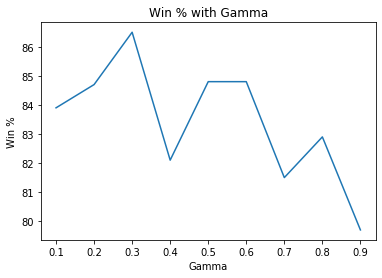

In [15]:
# data for gamma
gamma_data = []
result_data = []
for result in results:
    if result[1] == max_params[1] and result[2] == max_params[2]:
        gamma_data.append(result[0])
        result_data.append(result[-1])
plt.plot(gamma_data, result_data)
plt.title("Win % with Gamma")
plt.xlabel('Gamma')
plt.ylabel('Win %')
plt.show()

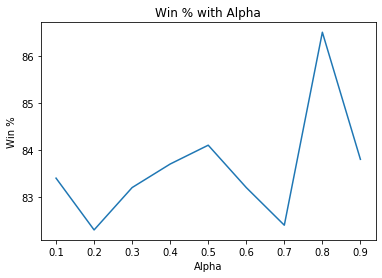

In [16]:
# data for alpha
alpha_data = []
result_data = []
for result in results:
    if result[0] == max_params[0] and result[2] == max_params[2]:
        alpha_data.append(result[1])
        result_data.append(result[-1])
plt.plot(alpha_data, result_data)
plt.title("Win % with Alpha")
plt.xlabel('Alpha')
plt.ylabel('Win %')
plt.show()

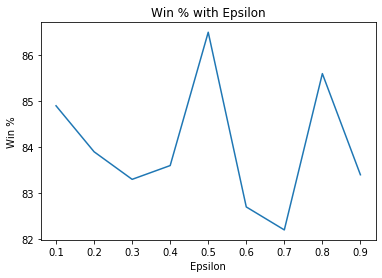

In [17]:
# data for epsilon
epsilon_data = []
result_data = []
for result in results:
    if result[1] == max_params[1] and result[0] == max_params[0]:
        epsilon_data.append(result[2])
        result_data.append(result[-1])
plt.plot(epsilon_data, result_data)
plt.title("Win % with Epsilon")
plt.xlabel('Epsilon')
plt.ylabel('Win %')
plt.show()

## Explanation of plots and choice of hyperparameters
Based on the plots, the chosen parameters are given by the max_params. The Q table obtained by choosing these parameters is then saved in the pickle file for future use.

## Final run for the best Q table

In [18]:
khyati_plays_rummy = RummyRLAgent()
khyati_plays_rummy.train(debug=False, save_q = True, gamma = max_params[0], alpha = max_params[1], epsilon = max_params[2])
won = 0
for i in range(100):
    x = khyati_plays_rummy.test(debug = False)
    if x:
        won += 1
print("final win %: ", won)

final win %:  83
